In [1]:
import pandas as pd

import statsmodels.api as sm
import pandas as pd
import datetime
from pathlib import Path

pd.set_option("display.max_columns", None)
# !pip install statsmodels


# %config InlineBackend.figure_format = "svg"
# %config InlineBackend.print_figure_kwargs = {"dpi" : 300}
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# from cadFace.vis import percentiles_plot
import sci_palettes

try:
    sci_palettes.register_cmap()
except:
    pass
import scienceplots
from pathlib import Path
import pandas as pd


plt.style.use(["nature", "no-latex"])
sns.set_context("paper", font_scale=1.5)
sns.set_palette("nejm")

In [2]:
ukbData = "/home/xutingfeng/ukb/ukbData/"

metabolismPath = ukbData + "omics/metabolomics/parsed/2024/init_visit_INT.pkl"
all_pheno_path = ukbData + "phenotypes/tf/all_pheno.pkl"

Part1_save_path = "result/metabolomics/"
Path(Part1_save_path).mkdir(parents=True, exist_ok=True)

In [5]:
shwan_data = ukbData + "dataset_final.tsv.gz"
shwan_data = pd.read_csv(shwan_data, sep="\s+")[["eid", "CHIP", "LTL", "PCE"]]
shwan_data

,eid,CHIP,LTL,PCE
0,1000017,0.0,-0.558629,0.115882
1,1000025,0.0,-0.605393,0.198147
2,1000038,0.0,0.567271,0.129878
3,1000042,0.0,-1.327370,0.126365
4,1000056,0.0,-0.796869,0.051227
...,...,...,...,...
420331,6024086,0.0,0.301398,0.155943
420332,6024098,0.0,-0.476101,0.256428
420333,6024103,0.0,-0.591265,0.302520
420334,6024110,0.0,-0.329481,0.165726


In [6]:
cofounders = ["assessment_center", "age", "sex", *[f"PC{i}" for i in range(1, 11)]]

risk_factors = [
    "age",
    "sex",
    "ldl_a",
    "hdl_a",
    "tc_a",
    "tg_a",
    "sbp_a",
    "BMI",
    "smoking",
    "prevalent_diabetes",
]

In [7]:
# loading data

metabolism = pd.read_pickle(metabolismPath)
all_pheno = pd.read_pickle(all_pheno_path)

In [54]:
if "index" in metabolism.columns:
    metabolism.drop("index", axis=1, inplace=True)
metabolism_symbol_list = metabolism.columns.tolist()
# metabolism = metabolism.set_index("eid")

In [9]:
all_pheno.reset_index(drop=False, inplace=True)

In [11]:
metabolism_missing_rate = (
    metabolism.isna().sum(axis=1) / metabolism.shape[1]
).sort_values(ascending=False)
metabolism_missing_rate

49795     0.941520
260940    0.877193
52442     0.783626
245438    0.192982
117757    0.192982
            ...   
93761     0.000000
93762     0.000000
93763     0.000000
93764     0.000000
274297    0.000000
Length: 274298, dtype: float64

<Axes: ylabel='Count'>

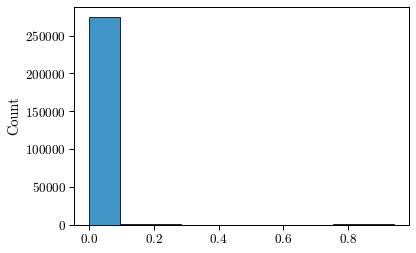

In [13]:
metabolism_missing_rate[metabolism_missing_rate > 0].index

Int64Index([ 49795, 260940,  52442, 245438, 117757, 241802,  55287, 108623,
            251461, 231853,
            ...
            139071, 150413,   7345, 148983, 145462,   8534, 140784, 274064,
              3006, 270275],
           dtype='int64', length=13319)

In [14]:
# 去除缺失率大于0。1的样本
missing_drop_rate = 0

to_drop = metabolism_missing_rate[metabolism_missing_rate > missing_drop_rate].index
print(f"drop {len(to_drop)} samples")
metabolism = metabolism.drop(to_drop)
# metabolism = metabolism.loc[to_drop]
print(f"after drop missing rate too high, left metabolism shape: {metabolism.shape}")
metabolism

drop 13319 samples
after drop missing rate too high, left metabolism shape: (260979, 171)


,eid,3-Hydroxybutyrate,Acetate,Acetoacetate,Acetone,Alanine,Albumin,Apolipoprotein A1,Apolipoprotein B,Average Diameter for HDL Particles,Average Diameter for LDL Particles,Average Diameter for VLDL Particles,Cholesterol in Chylomicrons and Extremely Large VLDL,Cholesterol in IDL,Cholesterol in Large HDL,Cholesterol in Large LDL,Cholesterol in Large VLDL,Cholesterol in Medium HDL,Cholesterol in Medium LDL,Cholesterol in Medium VLDL,Cholesterol in Small HDL,Cholesterol in Small LDL,Cholesterol in Small VLDL,Cholesterol in Very Large HDL,Cholesterol in Very Large VLDL,Cholesterol in Very Small VLDL,Cholesteryl Esters in Chylomicrons and Extremely Large VLDL,Cholesteryl Esters in HDL,Cholesteryl Esters in IDL,Cholesteryl Esters in LDL,Cholesteryl Esters in Large HDL,Cholesteryl Esters in Large LDL,Cholesteryl Esters in Large VLDL,Cholesteryl Esters in Medium HDL,Cholesteryl Esters in Medium LDL,Cholesteryl Esters in Medium VLDL,Cholesteryl Esters in Small HDL,Cholesteryl Esters in Small LDL,Cholesteryl Esters in Small VLDL,Cholesteryl Esters in VLDL,Cholesteryl Esters in Very Large HDL,Cholesteryl Esters in Very Large VLDL,Cholesteryl Esters in Very Small VLDL,Citrate,Clinical LDL Cholesterol,Concentration of Chylomicrons and Extremely Large VLDL Particles,Concentration of HDL Particles,Concentration of IDL Particles,Concentration of LDL Particles,Concentration of Large HDL Particles,Concentration of Large LDL Particles,Concentration of Large VLDL Particles,Concentration of Medium HDL Particles,Concentration of Medium LDL Particles,Concentration of Medium VLDL Particles,Concentration of Small HDL Particles,Concentration of Small LDL Particles,Concentration of Small VLDL Particles,Concentration of VLDL Particles,Concentration of Very Large HDL Particles,Concentration of Very Large VLDL Particles,Concentration of Very Small VLDL Particles,Creatinine,Degree of Unsaturation,Docosahexaenoic Acid,Free Cholesterol in Chylomicrons and Extremely Large VLDL,Free Cholesterol in HDL,Free Cholesterol in IDL,Free Cholesterol in LDL,Free Cholesterol in Large HDL,Free Cholesterol in Large LDL,Free Cholesterol in Large VLDL,Free Cholesterol in Medium HDL,Free Cholesterol in Medium LDL,Free Cholesterol in Medium VLDL,Free Cholesterol in Small HDL,Free Cholesterol in Small LDL,Free Cholesterol in Small VLDL,Free Cholesterol in VLDL,Free Cholesterol in Very Large HDL,Free Cholesterol in Very Large VLDL,Free Cholesterol in Very Small VLDL,Glucose,Glucose-lactate,Glutamine,Glycine,Glycoprotein Acetyls,HDL Cholesterol,Histidine,Isoleucine,LDL Cholesterol,Lactate,Leucine,Linoleic Acid,Monounsaturated Fatty Acids,Omega-3 Fatty Acids,Omega-6 Fatty Acids,Phenylalanine,Phosphatidylcholines,Phosphoglycerides,Phospholipids in Chylomicrons and Extremely Large VLDL,Phospholipids in HDL,Phospholipids in IDL,Phospholipids in LDL,Phospholipids in Large HDL,Phospholipids in Large LDL,Phospholipids in Large VLDL,Phospholipids in Medium HDL,Phospholipids in Medium LDL,Phospholipids in Medium VLDL,Phospholipids in Small HDL,Phospholipids in Small LDL,Phospholipids in Small VLDL,Phospholipids in VLDL,Phospholipids in Very Large HDL,Phospholipids in Very Large VLDL,Phospholipids in Very Small VLDL,Polyunsaturated Fatty Acids,Pyruvate,"Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)",Saturated Fatty Acids,Spectrometer-corrected alanine,Sphingomyelins,Total Cholesterol,Total Cholesterol Minus HDL-C,Total Cholines,Total Concentration of Branched-Chain Amino Acids (Leucine + Isoleucine + Valine),Total Concentration of Lipoprotein Particles,Total Esterified Cholesterol,Total Fatty Acids,Total Free Cholesterol,Total Lipids in Chylomicrons and Extremely Large VLDL,Total Lipids in HDL,Total Lipids in IDL,Total Lipids in LDL,Total Lipids in Large HDL,Total Lipids in Large LDL,Total Lipids in Large VLDL,Total Lipids in Lipoprotein Particles,Total Lipids in Medium HDL,Total Lipids in Medium LDL,Total Lipids in Medium VLDL,Total Lipids in Small HDL,Total Lipids in Small LDL,Tot

In [15]:
# mean impute RF


from ppp_prediction.impute import impute

all_pheno[risk_factors].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502409 entries, 0 to 502408
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 502406 non-null  float64
 1   sex                 502244 non-null  float64
 2   ldl_a               468617 non-null  float64
 3   hdl_a               429791 non-null  float64
 4   tc_a                469500 non-null  float64
 5   tg_a                469125 non-null  float64
 6   sbp_a               467969 non-null  float64
 7   BMI                 499415 non-null  float64
 8   smoking             499294 non-null  float64
 9   prevalent_diabetes  499627 non-null  float64
dtypes: float64(10)
memory usage: 38.3 MB


In [16]:
all_pheno[["ldl_a", "hdl_a", "tc_a", "tg_a", "sbp_a", "BMI"]] = impute(
    all_pheno[["ldl_a", "hdl_a", "tc_a", "tg_a", "sbp_a", "BMI"]],
    method="mean",
)
all_pheno[risk_factors].info()

 raw data is (502409, 6) and 102738 rows with na
Will use mean to replace na
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502409 entries, 0 to 502408
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 502406 non-null  float64
 1   sex                 502244 non-null  float64
 2   ldl_a               502409 non-null  float64
 3   hdl_a               502409 non-null  float64
 4   tc_a                502409 non-null  float64
 5   tg_a                502409 non-null  float64
 6   sbp_a               502409 non-null  float64
 7   BMI                 502409 non-null  float64
 8   smoking             499294 non-null  float64
 9   prevalent_diabetes  499627 non-null  float64
dtypes: float64(10)
memory usage: 38.3 MB


In [17]:
print(
    all_pheno["smoking"].value_counts(),
    all_pheno["smoking"].isna().sum(),
)
print(
    all_pheno["prevalent_diabetes"].value_counts(),
    all_pheno["prevalent_diabetes"].isna().sum(),
)

all_pheno["smoking"] = all_pheno["smoking"].fillna(0)
all_pheno["prevalent_diabetes"] = all_pheno["prevalent_diabetes"].fillna(0)


print(
    all_pheno["smoking"].value_counts(),
    all_pheno["smoking"].isna().sum(),
)
print(
    all_pheno["prevalent_diabetes"].value_counts(),
    all_pheno["prevalent_diabetes"].isna().sum(),
)

0.0    273391
1.0    172958
2.0     52945
Name: smoking, dtype: int64 3115
0.0    473236
1.0     26391
Name: prevalent_diabetes, dtype: int64 2782
0.0    276506
1.0    172958
2.0     52945
Name: smoking, dtype: int64 0
0.0    476018
1.0     26391
Name: prevalent_diabetes, dtype: int64 0


In [18]:
all_pheno[risk_factors].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502409 entries, 0 to 502408
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 502406 non-null  float64
 1   sex                 502244 non-null  float64
 2   ldl_a               502409 non-null  float64
 3   hdl_a               502409 non-null  float64
 4   tc_a                502409 non-null  float64
 5   tg_a                502409 non-null  float64
 6   sbp_a               502409 non-null  float64
 7   BMI                 502409 non-null  float64
 8   smoking             502409 non-null  float64
 9   prevalent_diabetes  502409 non-null  float64
dtypes: float64(10)
memory usage: 38.3 MB


In [19]:
# PRS

PRS_path = "/home/xutingfeng/ukb/ukbData/PRS/ldpred2_cxy.tsv"
PRS = pd.read_csv(PRS_path, sep="\t")
PRS.columns = ["eid", "PRS"]

PRS["eid"] = PRS["eid"].astype(int)
PRS["PRS"] = -1 * PRS["PRS"]  # this is because the wrong direction of PRS

PRS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487409 entries, 0 to 487408
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   eid     487409 non-null  int64  
 1   PRS     487409 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.4 MB


In [21]:
data_imputed = pd.merge(all_pheno, metabolism, on="eid", how="inner").merge(
    PRS, on="eid", how="inner"
)
data_imputed

,eid,sex,height,weight,BSA,genotype_array,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,assessment_center,age_squared,BMI,dbp_a,sbp_a,tc_a,tg_a,hdl_a,ldl_a,dbp,sbp,tc,tg,hdl,ldl,apob,cad,mi,crp,eGFR,Cr,CAD,cad_date,birth_date,recuit_date,death_date,cad_age,death_age,recuit_age,year_of_cad_after_recuit,survival_time,is_earily_CAD,incident_cad,cad_status,prevalent_cad,smoking,prevalent_diabetes,Arrhythmia,Stroke,Peripheral_vascular_disease,Hypertension,3-Hydroxybutyrate,Acetate,Acetoacetate,Acetone,Alanine,Albumin,Apolipoprotein A1,Apolipoprotein B,Average Diameter for HDL Particles,Average Diameter for LDL Particles,Average Diameter for VLDL Particles,Cholesterol in Chylomicrons and Extremely Large VLDL,Cholesterol in IDL,Cholesterol in Large HDL,Cholesterol in Large LDL,Cholesterol in Large VLDL,Cholesterol in Medium HDL,Cholesterol in Medium LDL,Cholesterol in Medium VLDL,Cholesterol in Small HDL,Cholesterol in Small LDL,Cholesterol in Small VLDL,Cholesterol in Very Large HDL,Cholesterol in Very Large VLDL,Cholesterol in Very Small VLDL,Cholesteryl Esters in Chylomicrons and Extremely Large VLDL,Cholesteryl Esters in HDL,Cholesteryl Esters in IDL,Cholesteryl Esters in LDL,Cholesteryl Esters in Large HDL,Cholesteryl Esters in Large LDL,Cholesteryl Esters in Large VLDL,Cholesteryl Esters in Medium HDL,Cholesteryl Esters in Medium LDL,Cholesteryl Esters in Medium VLDL,Cholesteryl Esters in Small HDL,Cholesteryl Esters in Small LDL,Cholesteryl Esters in Small VLDL,Cholesteryl Esters in VLDL,Cholesteryl Esters in Very Large HDL,Cholesteryl Esters in Very Large VLDL,Cholesteryl Esters in Very Small VLDL,Citrate,Clinical LDL Cholesterol,Concentration of Chylomicrons and Extremely Large VLDL Particles,Concentration of HDL Particles,Concentration of IDL Particles,Concentration of LDL Particles,Concentration of Large HDL Particles,Concentration of Large LDL Particles,Concentration of Large VLDL Particles,Concentration of Medium HDL Particles,Concentration of Medium LDL Particles,Concentration of Medium VLDL Particles,Concentration of Small HDL Particles,Concentration of Small LDL Particles,Concentration of Small VLDL Particles,Concentration of VLDL Particles,Concentration of Very Large HDL Particles,Concentration of Very Large VLDL Particles,Concentration of Very Small VLDL Particles,Creatinine,Degree of Unsaturation,Docosahexaenoic Acid,Free Cholesterol in Chylomicrons and Extremely Large VLDL,Free Cholesterol in HDL,Free Cholesterol in IDL,Free Cholesterol in LDL,Free Cholesterol in Large HDL,Free Cholesterol in Large LDL,Free Cholesterol in Large VLDL,Free Cholesterol in Medium HDL,Free Cholesterol in Medium LDL,Free Cholesterol in Medium VLDL,Free Cholesterol in Small HDL,Free Cholesterol in Small LDL,Free Cholesterol in Small VLDL,Free Cholesterol in VLDL,Free Cholesterol in Very Large HDL,Free Cholesterol in Very Large VLDL,Free Cholesterol in Very Small VLDL,Glucose,Glucose-lactate,Glutamine,Glycine,Glycoprotein Acetyls,HDL Cholesterol,Histidine,Isoleucine,LDL Cholesterol,Lactate,Leucine,Linoleic Acid,Monounsaturated Fatty Acids,Omega-3 Fatty Acids,Omega-6 Fatty Acids,Phenylalanine,Phosphatidylcholines,Phosphoglycerides,Phospholipids in Chylomicrons and Extremely Large VLDL,Phospholipids in HDL,Phospholipids in IDL,Phospholipids in LDL,Phospholipids in Large HDL,Phospholipids in Large LDL,Phospholipids in Large VLDL,Phospholipids in Medium HDL,Phospholipids in Medium LDL,Phospholipids in Medium VLDL,Phospholipids in Small HDL,Phospholipids in Small LDL,Phospholipids in Small VLDL,Phospholipids in VLDL,Phospholipids in Very Large HDL,Phospholipids in Very Large VLDL,Phospholipids in Very Small VLDL,Polyunsaturated Fatty Acids,Pyruvate,"Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)",Saturated Fatty Acids,Spectrometer-corrected alanine,Sphingomyelins,Total Cholesterol,Total Cholesterol Minus HDL-C,Total Cholines,Total Concentration of Branched-Chain Amino Acids (Leucine + Isoleucine + Valine),Total Concentration of Lipoprotein

In [24]:
data_imputed = data_imputed.merge(shwan_data, on="eid", how="left")
data_imputed

In [25]:
import numpy as np


def define_time(data, Target="incident_cad_rate"):
    if Target == "incident_cad_rate":
        # data = data[data['incident_cad'] == 1]
        df = data[data["incident_cad"] != -1]

        def survival_time(x):
            cad_date = x["cad_date"]
            death_date = x["death_date"]
            recuit_date = x["recuit_date"]
            if pd.isnull(cad_date) and pd.isnull(death_date):
                return datetime.datetime.now() - recuit_date
            elif pd.isnull(cad_date) and pd.notnull(death_date):
                return death_date - recuit_date
            elif pd.notnull(cad_date) and pd.isnull(death_date):
                return datetime.datetime.now() - cad_date
            else:  # cad and death
                # raise ValueError(f"error, should not happen with {x}")
                return cad_date - recuit_date

        df.loc[:, "future_cad_time_days"] = df.apply(survival_time, axis=1)
        df["future_cad_time_months"] = np.ceil(df["future_cad_time_days"].dt.days / 30)
        df["future_cad_time_years"] = np.ceil(df["future_cad_time_days"].dt.days / 365)
        # df = df.reset_index(drop=True)

        E = "incident_cad"
        T = "future_cad_time_months"
        print(f"{E} have NA: {df[E].isna().sum()}, drop them")
        df = df.dropna(subset=[E])
        print(f"{T} have NA: {df[T].isna().sum()}, drop them")
        df = df.dropna(subset=[T])

        print(f"{E} and {T} dtype is {df[E].dtype} and {df[T].dtype}")
        if df[E].dtype != float:
            df[E] = df[E].astype(float)
        if df[T].dtype != float:
            df[T] = df[T].astype(float)

        print(f"Finnal used sample size: {df.shape[0]}")
        print(f"{E} value counts is : {df[E].value_counts()}")

        return df, E, T


data_imputed, E, T = define_time(data_imputed)
data_imputed

/tmp/ipykernel_1317/3819369207.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "future_cad_time_days"] = df.apply(survival_time, axis=1)
/tmp/ipykernel_1317/3819369207.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["future_cad_time_months"] = np.ceil(df["future_cad_time_days"].dt.days / 30)
/tmp/ipykernel_1317/3819369207.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

incident_cad have NA: 44, drop them
future_cad_time_months have NA: 0, drop them
incident_cad and future_cad_time_months dtype is object and float64
Finnal used sample size: 251865
incident_cad value counts is : 0.0    239009
1.0     12856
Name: incident_cad, dtype: int64


,eid,sex,height,weight,BSA,genotype_array,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,assessment_center,age_squared,BMI,dbp_a,sbp_a,tc_a,tg_a,hdl_a,ldl_a,dbp,sbp,tc,tg,hdl,ldl,apob,cad,mi,crp,eGFR,Cr,CAD,cad_date,birth_date,recuit_date,death_date,cad_age,death_age,recuit_age,year_of_cad_after_recuit,survival_time,is_earily_CAD,incident_cad,cad_status,prevalent_cad,smoking,prevalent_diabetes,Arrhythmia,Stroke,Peripheral_vascular_disease,Hypertension,3-Hydroxybutyrate,Acetate,Acetoacetate,Acetone,Alanine,Albumin,Apolipoprotein A1,Apolipoprotein B,Average Diameter for HDL Particles,Average Diameter for LDL Particles,Average Diameter for VLDL Particles,Cholesterol in Chylomicrons and Extremely Large VLDL,Cholesterol in IDL,Cholesterol in Large HDL,Cholesterol in Large LDL,Cholesterol in Large VLDL,Cholesterol in Medium HDL,Cholesterol in Medium LDL,Cholesterol in Medium VLDL,Cholesterol in Small HDL,Cholesterol in Small LDL,Cholesterol in Small VLDL,Cholesterol in Very Large HDL,Cholesterol in Very Large VLDL,Cholesterol in Very Small VLDL,Cholesteryl Esters in Chylomicrons and Extremely Large VLDL,Cholesteryl Esters in HDL,Cholesteryl Esters in IDL,Cholesteryl Esters in LDL,Cholesteryl Esters in Large HDL,Cholesteryl Esters in Large LDL,Cholesteryl Esters in Large VLDL,Cholesteryl Esters in Medium HDL,Cholesteryl Esters in Medium LDL,Cholesteryl Esters in Medium VLDL,Cholesteryl Esters in Small HDL,Cholesteryl Esters in Small LDL,Cholesteryl Esters in Small VLDL,Cholesteryl Esters in VLDL,Cholesteryl Esters in Very Large HDL,Cholesteryl Esters in Very Large VLDL,Cholesteryl Esters in Very Small VLDL,Citrate,Clinical LDL Cholesterol,Concentration of Chylomicrons and Extremely Large VLDL Particles,Concentration of HDL Particles,Concentration of IDL Particles,Concentration of LDL Particles,Concentration of Large HDL Particles,Concentration of Large LDL Particles,Concentration of Large VLDL Particles,Concentration of Medium HDL Particles,Concentration of Medium LDL Particles,Concentration of Medium VLDL Particles,Concentration of Small HDL Particles,Concentration of Small LDL Particles,Concentration of Small VLDL Particles,Concentration of VLDL Particles,Concentration of Very Large HDL Particles,Concentration of Very Large VLDL Particles,Concentration of Very Small VLDL Particles,Creatinine,Degree of Unsaturation,Docosahexaenoic Acid,Free Cholesterol in Chylomicrons and Extremely Large VLDL,Free Cholesterol in HDL,Free Cholesterol in IDL,Free Cholesterol in LDL,Free Cholesterol in Large HDL,Free Cholesterol in Large LDL,Free Cholesterol in Large VLDL,Free Cholesterol in Medium HDL,Free Cholesterol in Medium LDL,Free Cholesterol in Medium VLDL,Free Cholesterol in Small HDL,Free Cholesterol in Small LDL,Free Cholesterol in Small VLDL,Free Cholesterol in VLDL,Free Cholesterol in Very Large HDL,Free Cholesterol in Very Large VLDL,Free Cholesterol in Very Small VLDL,Glucose,Glucose-lactate,Glutamine,Glycine,Glycoprotein Acetyls,HDL Cholesterol,Histidine,Isoleucine,LDL Cholesterol,Lactate,Leucine,Linoleic Acid,Monounsaturated Fatty Acids,Omega-3 Fatty Acids,Omega-6 Fatty Acids,Phenylalanine,Phosphatidylcholines,Phosphoglycerides,Phospholipids in Chylomicrons and Extremely Large VLDL,Phospholipids in HDL,Phospholipids in IDL,Phospholipids in LDL,Phospholipids in Large HDL,Phospholipids in Large LDL,Phospholipids in Large VLDL,Phospholipids in Medium HDL,Phospholipids in Medium LDL,Phospholipids in Medium VLDL,Phospholipids in Small HDL,Phospholipids in Small LDL,Phospholipids in Small VLDL,Phospholipids in VLDL,Phospholipids in Very Large HDL,Phospholipids in Very Large VLDL,Phospholipids in Very Small VLDL,Polyunsaturated Fatty Acids,Pyruvate,"Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)",Saturated Fatty Acids,Spectrometer-corrected alanine,Sphingomyelins,Total Cholesterol,Total Cholesterol Minus HDL-C,Total Cholines,Total Concentration of Branched-Chain Amino Acids (Leucine + Isoleucine + Valine),Total Concentration of Lipoprotein

In [26]:
# 数据集切分

from sklearn.model_selection import train_test_split

train_imputed, test_imputed = train_test_split(
    data_imputed, test_size=0.2, random_state=42
)

print(f"train shape: {train_imputed.shape}, test shape: {test_imputed.shape}")
print(
    f"train {E} have {train_imputed[E].value_counts()}, test {E} have {test_imputed[E].value_counts()}"
)

train shape: (201492, 235), test shape: (50373, 235)
train incident_cad have 0.0    191217
1.0     10275
Name: incident_cad, dtype: int64, test incident_cad have 0.0    47792
1.0     2581
Name: incident_cad, dtype: int64


In [28]:
score_dict = {
    "Metabolism": metabolism_symbol_list,
    "RF": risk_factors,
    "PRS": ["PRS"],
    "Metabolism + AS": metabolism_symbol_list + ["age", "sex"],
    "AS": ["age", "sex"],
    "Metabolism + RF": metabolism_symbol_list + risk_factors,
    "Metabolism + PRS": metabolism_symbol_list + ["PRS"],
    "Metabolism + RF + PRS": metabolism_symbol_list + risk_factors + ["PRS"],
    "RF + PRS": risk_factors + ["PRS"],
    "SomaticRS": ["CHIP", "LTL"],
    "Metabolism + SomaticRS": metabolism_symbol_list + ["CHIP", "LTL"],
    "RF + SomaticRS": risk_factors + ["CHIP", "LTL"],
    "Metabolism + RF + SomaticRS": metabolism_symbol_list
    + risk_factors
    + ["CHIP", "LTL"],
    "Metabolism + PRS + SomaticRS": metabolism_symbol_list + ["PRS", "CHIP", "LTL"],
    "RF + PRS + SomaticRS": risk_factors + ["PRS", "CHIP", "LTL"],
    "Metabolism + RF + PRS + SomaticRS": metabolism_symbol_list
    + risk_factors
    + ["PRS", "CHIP", "LTL"],
    "SomaticRS + AS": ["CHIP", "LTL", "age", "sex"],
}

score_json = {k: {"features": v, "label": E} for k, v in score_dict.items()}


import json

json.dump(score_json, open("result/cad_dict.json", "w"))

score_dict.keys()

dict_keys(['Metabolism', 'RF', 'PRS', 'Metabolism + AS', 'AS', 'Metabolism + RF', 'Metabolism + PRS', 'Metabolism + RF + PRS', 'RF + PRS', 'SomaticRS', 'Metabolism + SomaticRS', 'RF + SomaticRS', 'Metabolism + RF + SomaticRS', 'Metabolism + PRS + SomaticRS', 'RF + PRS + SomaticRS', 'Metabolism + RF + PRS + SomaticRS', 'SomaticRS + AS'])

In [29]:
from ppp_prediction.model import fit_best_model
from ppp_prediction.model import cal_binary_metrics_bootstrap
import pickle

res = []

score_model_dir = f"{Part1_save_path}/score_model"
Path(score_model_dir).mkdir(parents=True, exist_ok=True)
score_model_dict = {}

for name, X_var in score_dict.items():
    if name not in train_imputed.columns:
        save_obj_dir = f"{score_model_dir}/{name}.pkl"
        if Path(save_obj_dir).exists():
            print(f"Already have {name}, skip")
            continue
        (
            model,
            train_metrics,
            test_metrics,
            train_imputed_data,
            test_imputed_data,
            best_models,
        ) = fit_best_model(
            train_df=train_imputed,
            test_df=test_imputed,
            X_var=X_var,
            y_var="incident_cad",
            method_list="Lasso",
            cv=5,
        )

        model_obj = {
            "model": model,
            "train_metrics": train_metrics,
            "test_metrics": test_metrics,
        }
        test_imputed_data.rename(columns={"incident_cad_pred": name}, inplace=True)
        train_imputed_data.rename(columns={"incident_cad_pred": name}, inplace=True)
        test_imputed[name] = test_imputed_data[name]
        train_imputed[name] = train_imputed_data[name]

        pickle.dump(model_obj, open(save_obj_dir, "wb"))
    else:
        to_cal_test = test_imputed[["incident_cad", name]].dropna()
        test_metrics = cal_binary_metrics_bootstrap(
            to_cal_test["incident_cad"],
            to_cal_test[name],
            ci_kwargs={"n_resamples": 100},
        )

    test_metrics["method"] = name
    res.append(test_metrics)


res_df = pd.DataFrame(res)
res_df

[I] [19:36:36.906419] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (181342, 171), val shape is (20150, 171), test shape is (50373, 171)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 7.742636826811277e-06}, with auc: 0.6972567455481711


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Already have RF, skip
Already have Metabolism + AS, skip
Already have AS, skip
Already have Metabolism + RF, skip
Already have Metabolism + PRS, skip
Already have Metabolism + RF + PRS, skip
Already have RF + PRS, skip
[I] [19:39:22.042277] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 2), val shape is (16197, 2), test shape is (40366, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 0.00046415888336127773}, with auc: 0.5691286241567625
[I] [19:39:27.763334] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 173), val shape is (16197, 173), test shape is (40366, 173)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 1e-06}, with auc: 0.7216049627492438


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[I] [19:41:38.770418] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 12), val shape is (16197, 12), test shape is (40366, 12)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 0.00046415888336127773}, with auc: 0.7642790864404709
[I] [19:41:47.323780] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 183), val shape is (16197, 183), test shape is (40366, 183)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 5.994842503189409e-05}, with auc: 0.7745636895141145


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[I] [19:43:48.452222] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 174), val shape is (16197, 174), test shape is (40366, 174)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 7.742636826811277e-06}, with auc: 0.7539990832047229


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[I] [19:45:55.778400] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 13), val shape is (16197, 13), test shape is (40366, 13)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 0.00046415888336127773}, with auc: 0.7915914963272673
[I] [19:46:04.350624] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 184), val shape is (16197, 184), test shape is (40366, 184)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 0.00046415888336127773}, with auc: 0.7985713537957386


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[I] [19:48:05.362555] Unused keyword parameter: random_state during cuML estimator initialization
train shape: (145766, 4), val shape is (16197, 4), test shape is (40366, 4)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


model: Lasso	Best parameters: {'model__alpha': 0.00046415888336127773}, with auc: 0.7233213367446154


,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,Sensitivity_UCI,Sensitivity_LCI,Specificity,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,method
0,0.710891,0.721245,0.700500,0.652631,0.656863,0.648601,0.472150,0.476564,0.467968,0.662534,0.677384,0.642278,0.652097,0.656156,0.648267,0.122689,0.131155,0.113900,50373,2581.0,47792.0,Metabolism
1,0.640290,0.649956,0.630687,0.539853,0.544333,0.536437,0.409065,0.412002,0.405740,0.677257,0.692354,0.658169,0.532432,0.536586,0.527667,0.086914,0.092415,0.081629,50373,2581.0,47792.0,PRS
2,0.561228,0.572753,0.547775,0.549695,0.554431,0.545746,0.406015,0.409871,0.402002,0.557252,0.574730,0.534287,0.549281,0.553951,0.543944,0.063263,0.067595,0.059483,40366,2096.0,38270.0,SomaticRS
3,0.709568,0.721624,0.698389,0.671778,0.675894,0.667366,0.481996,0.486488,0.477114,0.640267,0.658937,0.621034,0.673504,0.678933,0.668737,0.125181,0.136100,0.114332,40366,2096.0,38270.0,Metabolism + SomaticRS
4,0.748301,0.757544,0.738442,0.642917,0.647760,0.638378,0.474628,0.479681,0.469990,0.740935,0.759687,0.724090,0.637549,0.642483,0.633151,0.139085,0.148542,0.128107,40366,2096.0,38270.0,RF + SomaticRS
5,0.761629,0.770721,0.752911,0.654610,0.658772,0.649624,0.481900,0.486208,0.476620,0.743798,0.763104,0.727408,0.649726,0.654346,0.645214,0.157345,0.168243,0.145091,40366,2096.0,38270.0,Metabolism + RF + SomaticRS
6,0.741317,0.751794,0.730345,0.721028,0.725575,0.717582,0.511208,0.516289,0.505936,0.634065,0.654561,0.615857,0.725790,0.730767,0.721077,0.148691,0.159138,0.137492,40366,2096.0,38270.0,Metabolism + PRS + SomaticRS
7,0.776048,0.787047,0.766041,0.681217,0.685950,0.677202,0.498575,0.503100,0.494078,0.748092,0.768512,0.729221,0.677554,0.681673,0.672434,0.164372,0.176599,0.153107,40366,2096.0,38270.0,RF + PRS + SomaticRS
8,0.784092,0.793992,0.774705,0.707823,0.711666,0.703632,0.514349,0.518834,0.510129,0.738073,0.759896,0.721831,0.706167,0.710371,0.701317,0.179254,0.192474,0.166378,40366,2096.0,38270.0,Metabolism + RF + PRS + SomaticRS
9,0.703932,0.713889,0.693141,0.585369,0.589769,0.580860,0.439911,0.443535,0.435876,0.729485,0.750214,0.712364,0.577476,0.582773,0.573320,0.106464,0.112718,0.098137,40366,2096.0,38270.0,SomaticRS + AS


In [31]:
res_df.sort_values("AUC", ascending=False)

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,Sensitivity_UCI,Sensitivity_LCI,Specificity,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,method
8,0.784092,0.793992,0.774705,0.707823,0.711666,0.703632,0.514349,0.518834,0.510129,0.738073,0.759896,0.721831,0.706167,0.710371,0.701317,0.179254,0.192474,0.166378,40366,2096.0,38270.0,Metabolism + RF + PRS + SomaticRS
7,0.776048,0.787047,0.766041,0.681217,0.685950,0.677202,0.498575,0.503100,0.494078,0.748092,0.768512,0.729221,0.677554,0.681673,0.672434,0.164372,0.176599,0.153107,40366,2096.0,38270.0,RF + PRS + SomaticRS
5,0.761629,0.770721,0.752911,0.654610,0.658772,0.649624,0.481900,0.486208,0.476620,0.743798,0.763104,0.727408,0.649726,0.654346,0.645214,0.157345,0.168243,0.145091,40366,2096.0,38270.0,Metabolism + RF + SomaticRS
4,0.748301,0.757544,0.738442,0.642917,0.647760,0.638378,0.474628,0.479681,0.469990,0.740935,0.759687,0.724090,0.637549,0.642483,0.633151,0.139085,0.148542,0.128107,40366,2096.0,38270.0,RF + SomaticRS
6,0.741317,0.751794,0.730345,0.721028,0.725575,0.717582,0.511208,0.516289,0.505936,0.634065,0.654561,0.615857,0.725790,0.730767,0.721077,0.148691,0.159138,0.137492,40366,2096.0,38270.0,Metabolism + PRS + SomaticRS
0,0.710891,0.721245,0.700500,0.652631,0.656863,0.648601,0.472150,0.476564,0.467968,0.662534,0.677384,0.642278,0.652097,0.656156,0.648267,0.122689,0.131155,0.113900,50373,2581.0,47792.0,Metabolism
3,0.709568,0.721624,0.698389,0.671778,0.675894,0.667366,0.481996,0.486488,0.477114,0.640267,0.658937,0.621034,0.673504,0.678933,0.668737,0.125181,0.136100,0.114332,40366,2096.0,38270.0,Metabolism + SomaticRS
9,0.703932,0.713889,0.693141,0.585369,0.589769,0.580860,0.439911,0.443535,0.435876,0.729485,0.750214,0.712364,0.577476,0.582773,0.573320,0.106464,0.112718,0.098137,40366,2096.0,38270.0,SomaticRS + AS
1,0.640290,0.649956,0.630687,0.539853,0.544333,0.536437,0.409065,0.412002,0.405740,0.677257,0.692354,0.658169,0.532432,0.536586,0.527667,0.086914,0.092415,0.081629,50373,2581.0,47792.0,PRS
2,0.561228,0.572753,0.547775,0.549695,0.554431,0.545746,0.406015,0.409871,0.402002,0.557252,0.574730,0.534287,0.549281,0.553951,0.543944,0.063263,0.067595,0.059483,40366,2096.0,38270.0,SomaticRS


In [36]:
model = pd.read_pickle(f"{Part1_save_path}/score_model/Metabolism.pkl")["model"]

In [58]:
train_imputed["type"] = "train"
test_imputed["type"] = "test"

pd.concat([train_imputed, test_imputed]).to_pickle(
    f"{Part1_save_path}/data_with_score.pkl"
)

In [37]:
data = pd.DataFrame(
    zip(model.feature_names_in_, model["model"].coef_), columns=["feature", "coef"]
).sort_values("coef")
data

,feature,coef
7,Apolipoprotein A1,-0.049857
90,LDL Cholesterol,-0.042338
125,Total Cholines,-0.040873
107,Phospholipids in Medium HDL,-0.039888
39,Cholesteryl Esters in VLDL,-0.037246
...,...,...
96,Omega-6 Fatty Acids,0.041631
123,Total Cholesterol,0.045534
57,Concentration of Small VLDL Particles,0.045665
104,Phospholipids in Large HDL,0.048334


<Axes: xlabel='coef', ylabel='feature'>

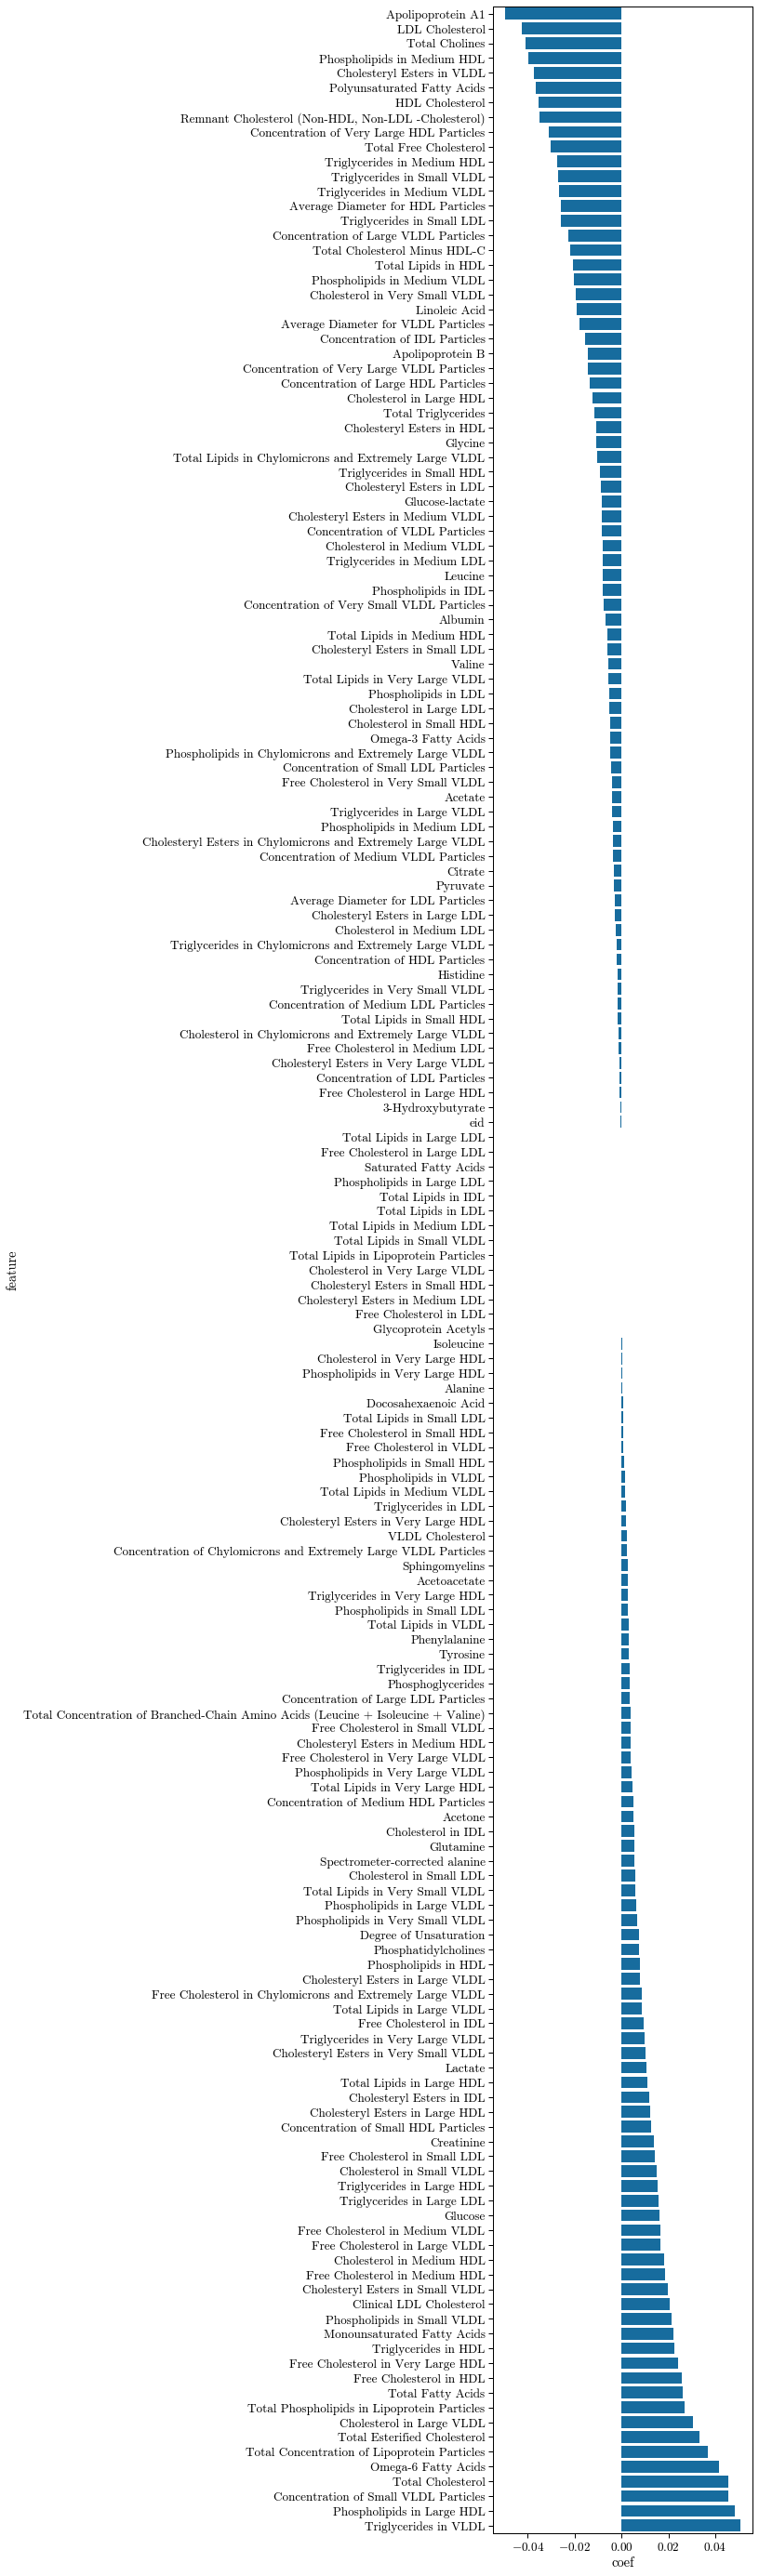

In [41]:
fig, ax = plt.subplots(figsize=(5, 50))
sns.barplot(data=data, x="coef", y="feature", ax=ax)

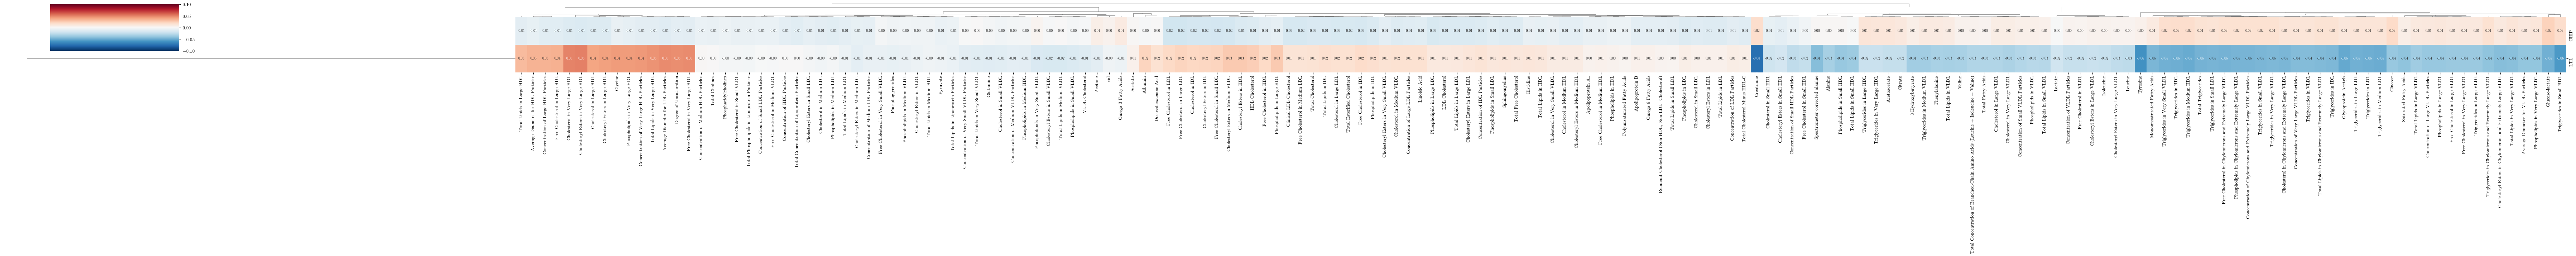

In [53]:
sns.clustermap(
    test_imputed[["CHIP", "LTL"] + metabolism_symbol_list]
    .corr()
    .loc[metabolism_symbol_list][["CHIP", "LTL"]]
    .T,
    figsize=(100, 10),
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-0.1,
    vmax=0.1,
    # square=True,
)